In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def show_img(img, gray=False, splt=111, title="Image",axis="off", in_cv2=False):
    if in_cv2:
        show_cv2_img(img)
        return
    
    if type(splt) == int:
        plt.subplot(splt)
    else:
        plt.subplot(*splt)
    
#     plt.subplot(splt)
    plt.axis(axis)
    plt.title(title)
    if gray:
        plt.imshow(img, "gray")
    else:
        plt.imshow(img)

In [3]:
def show_imgs(*args,grid=None,gray=False):
    grid = grid or (len(args), 1)
    if len(args) == 2:
        plt.subplots_adjust(top=2, right=2)
        grid = (1,2)
    else:
        plt.subplots_adjust(top=grid[0], right=grid[1])
    print(grid)
    for i, img in enumerate(args):
        splt= grid+(i+1,)
        print(splt)
        show_img(args[i], gray=gray, splt=splt)

In [4]:
def show_cv2_img(img):
    cv2.imshow('sdf', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [26]:
def noisy(image):
    row,col= image.shape
    mean = 0
    var = 10
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    return noisy

(1947, 2921, 3)


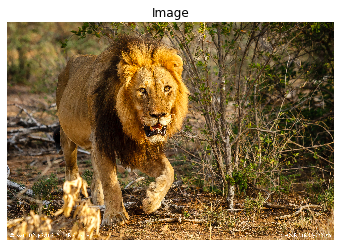

In [20]:
img_bgr = cv2.imread('../images/lion.jpg')
print(img_bgr.shape)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_rgb = np.copy(img_bgr[:,:,::-1])
show_img(img_rgb)
img_gray = cv2.resize(img_gray,None,fx=0.3,fy=0.3)

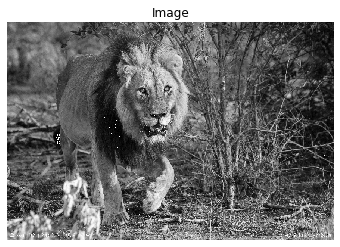

In [29]:
img_noise = noisy(img_gray)
show_img(img_noise.astype(np.uint8),gray=True)

In [32]:
def gaussian(x,y,sigma):
    return np.exp(-np.power(x-y,2)/(2*sigma**2))

def weight(img,d,sigma=0.2):
    dis = np.zeros(img.shape)
    w = np.zeros(img.shape)
    nx, ny = (1, 1)
    x = np.linspace(1, d, d)
    y = np.linspace(1, d, d)
    xv, yv = np.meshgrid(x, y)
    x = np.abs(xv - np.ceil(d/2))
    m = x + x.T
    dis[m%2==1] = 1
    ind = np.ceil((d-1)/2).astype(np.int)
    dis[ind,:] = 0 
    dis[:,ind] = 1 
    w[ind,ind] = 1

    # adjacent pixels
    w[ind,ind+1] = gaussian(img[ind,ind],img[ind,ind+1],sigma)
    w[ind+1,ind] = gaussian(img[ind,ind],img[ind+1,ind],sigma)
    w[ind-1,ind] = gaussian(img[ind,ind],img[ind-1,ind],sigma)
    w[ind,ind-1] = gaussian(img[ind,ind],img[ind,ind-1],sigma)
    
    #pixels in same row
    t = w[ind,ind+1]
    for i in range(ind+2,d):
        w[ind,i] = w[ind,ind+1]*t*gaussian(img[ind,ind],img[ind,i],sigma)
        
    t = w[ind,ind-1]
    for i in range(0,ind-1):
        w[ind,i] = w[ind,ind-1]*t*gaussian(img[ind,ind],img[ind,i],sigma)
    
    #pixels in same column
    t = w[ind+1,ind]
    for i in range(ind+2,d):
        w[i,ind] = w[ind+1,ind]*t*gaussian(img[ind,ind],img[i,ind],sigma)
        
    t = w[ind-1,ind]
    for i in range(0,ind-1):
        w[i,ind] = w[ind-1,ind]*t*gaussian(img[ind,ind],img[i,ind],sigma)
        
    # Q1
    for i in range(ind-1,0,-1):
        for j in range(ind+1,d):
            if dis[i,j]==1:
                w[i,j] = w[i+1,j]*gaussian(img[ind,ind],img[i,j],sigma)*gaussian(img[i+1,j],img[i,j],sigma)
            else:
                w[i,j] = w[i,j-1]*gaussian(img[ind,ind],img[i,j],sigma)*gaussian(img[i,j-1],img[i,j],sigma)
    # Q2
    for i in range(ind-1,0,-1):
        for j in range(ind-1,-1,-1):
            if dis[i,j]==1:
                w[i,j] = w[i+1,j]*gaussian(img[ind,ind],img[i,j],sigma)*gaussian(img[i+1,j],img[i,j],sigma)
            else:
                w[i,j] = w[i,j+1]*gaussian(img[ind,ind],img[i,j],sigma)*gaussian(img[i,j+1],img[i,j],sigma)
    # Q3
    for i in range(ind+1,d):
        for j in range(ind-1,-1,-1):
            if dis[i,j]==1:
                w[i,j] = w[i-1,j]*gaussian(img[ind,ind],img[i,j],sigma)*gaussian(img[i-1,j],img[i,j],sigma)
            else:
                w[i,j] = w[i,j+1]*gaussian(img[ind,ind],img[i,j],sigma)*gaussian(img[i,j+1],img[i,j],sigma)

    # Q4
    for i in range(ind+1,d):
        for j in range(ind+1,d):
            if dis[i,j]==1:
                w[i,j] = w[i-1,j]*gaussian(img[ind,ind],img[i,j],sigma)*gaussian(img[i-1,j],img[i,j],sigma)
            else:
                w[i,j] = w[i,j-1]*gaussian(img[ind,ind],img[i,j],sigma)*gaussian(img[i,j-1],img[i,j],sigma)
    return w
def propogative_filtering(img,d=5):
    try:
        h,w,c = img.shape[:]
    except:
        h,w = img.shape[:]
        c =1
    pad_img = np.pad(img,(d,d),'edge')
    out = np.zeros(img.shape)
    for i in range(d,h+d):
        print(i,end=" ")
        for j in range(d,w+d):
            for k in range(c):
                wei = weight(pad_img[i-d:i+d+1,j-d:j+d+1].astype(np.float64),d*2+1,0.12)
                print(wei)
                break
                out[i-d,j-d] = np.sum(np.multiply(wei,pad_img[i-d:i+d+1,j-d:j+d+1]))/np.sum(wei)
            break
        break    
    return out.astype(np.uint32)

In [33]:
print(img_gray.shape)
out = propogative_filtering(img_gray,d=3)

(584, 876)
3 [[0.00000000e+000 0.00000000e+000 0.00000000e+000 1.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  5.31236408e-242 0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  3.68085585e-272 0.00000000e+000 0.00000000e+000]
 [6.92884712e-031 5.76755133e-046 6.92884712e-031 8.32396968e-016
  0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000]]


In [24]:
out.shape

(584, 876)

In [137]:
cv2.imwrite("out.jpg",out.astype(np.uint8))

True

In [90]:
w[:,ind]

array([0.011109  , 0.01831564, 0.13533528, 1.        , 0.60653066,
       0.36787944, 0.36787944])

In [91]:
img[:,ind]

array([113., 114., 116., 114., 113., 114., 114.])

In [122]:
img_gray.shape

(1947, 2921)

In [ ]:
show_img(out)